<a href="https://colab.research.google.com/github/jc13605-0721/ECE_6143_ML_Project/blob/main/mushroom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
# Load data & basic info
from IPython.display import display

# Load dataset from URL
df = pd.read_csv("https://raw.githubusercontent.com/jc13605-0721/ECE_6143_ML_Project/main/mushrooms.csv")

print("First 5 rows:")
# Preview data structure
display(df.head())

print("\nBasic information:")
# Check types and missing values
print(df.info())

print("\nClass distribution:")
# Check target balance
print(df["class"].value_counts())

First 5 rows:


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g



Basic information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stal

In [3]:
# Split & preprocessor

# Map target: e=0 (edible), p=1 (poisonous)
X = df.drop(columns=["class"])
y = df["class"].map({"e": 0, "p": 1})

feature_names = X.columns.tolist()
print("Feature count:", len(feature_names))

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

categorical_features = feature_names

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

Feature count: 22
Train set shape: (6499, 22)
Test set shape: (1625, 22)


In [5]:
# Evaluation helper
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate probabilities/scores for ROC AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_prob)
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
        roc = roc_auc_score(y_test, scores)
    else:
        roc = np.nan

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    # Print performance report
    print("=" * 40)
    print(f"Model: {name}")
    print("=" * 40)
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC AUC  : {roc:.4f}")
    print("\nConfusion Matrix (Row=True, Col=Pred)")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    return {
        "name": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "cm": cm,
        "model": model
    }

In [6]:
# Baseline models (LogReg / KNN / DT / RF)
# Define a dictionary of classifiers to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

results = []

for name, clf in models.items():
    # Create pipeline: Preprocessor + Classifier
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", clf)
    ])

    # Train, predict, and store results
    res = evaluate_model(name, pipe, X_train, X_test, y_train, y_test)
    results.append(res)

# Create a summary DataFrame for easy comparison
summary_df = pd.DataFrame([
    {
        "model": r["name"],
        "accuracy": r["accuracy"],
        "precision": r["precision"],
        "recall": r["recall"],
        "f1": r["f1"],
        "roc_auc": r["roc_auc"]
    }
    for r in results
])

print("\nModel Performance Summary:")
display(summary_df)

Model: Logistic Regression
Accuracy : 0.9994
Precision: 1.0000
Recall   : 0.9987
F1-score : 0.9994
ROC AUC  : 1.0000

Confusion Matrix (Row=True, Col=Pred)
[[842   0]
 [  1 782]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Model: KNN (k=5)
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
ROC AUC  : 1.0000

Confusion Matrix (Row=True, Col=Pred)
[[842   0]
 [  0 783]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weigh

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.999385,1.0,0.998723,0.999361,1.0
1,KNN (k=5),1.000000,1.0,1.000000,1.000000,1.0
2,Decision Tree,1.000000,1.0,1.000000,1.000000,1.0
3,Random Forest,1.000000,1.0,1.000000,1.000000,1.0


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Decision Tree Params: {'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best CV F1 Score: 0.9996805111821085
Model: Decision Tree (tuned)
Accuracy : 0.9988
Precision: 1.0000
Recall   : 0.9974
F1-score : 0.9987
ROC AUC  : 0.9990

Confusion Matrix (Row=True, Col=Pred)
[[842   0]
 [  2 781]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



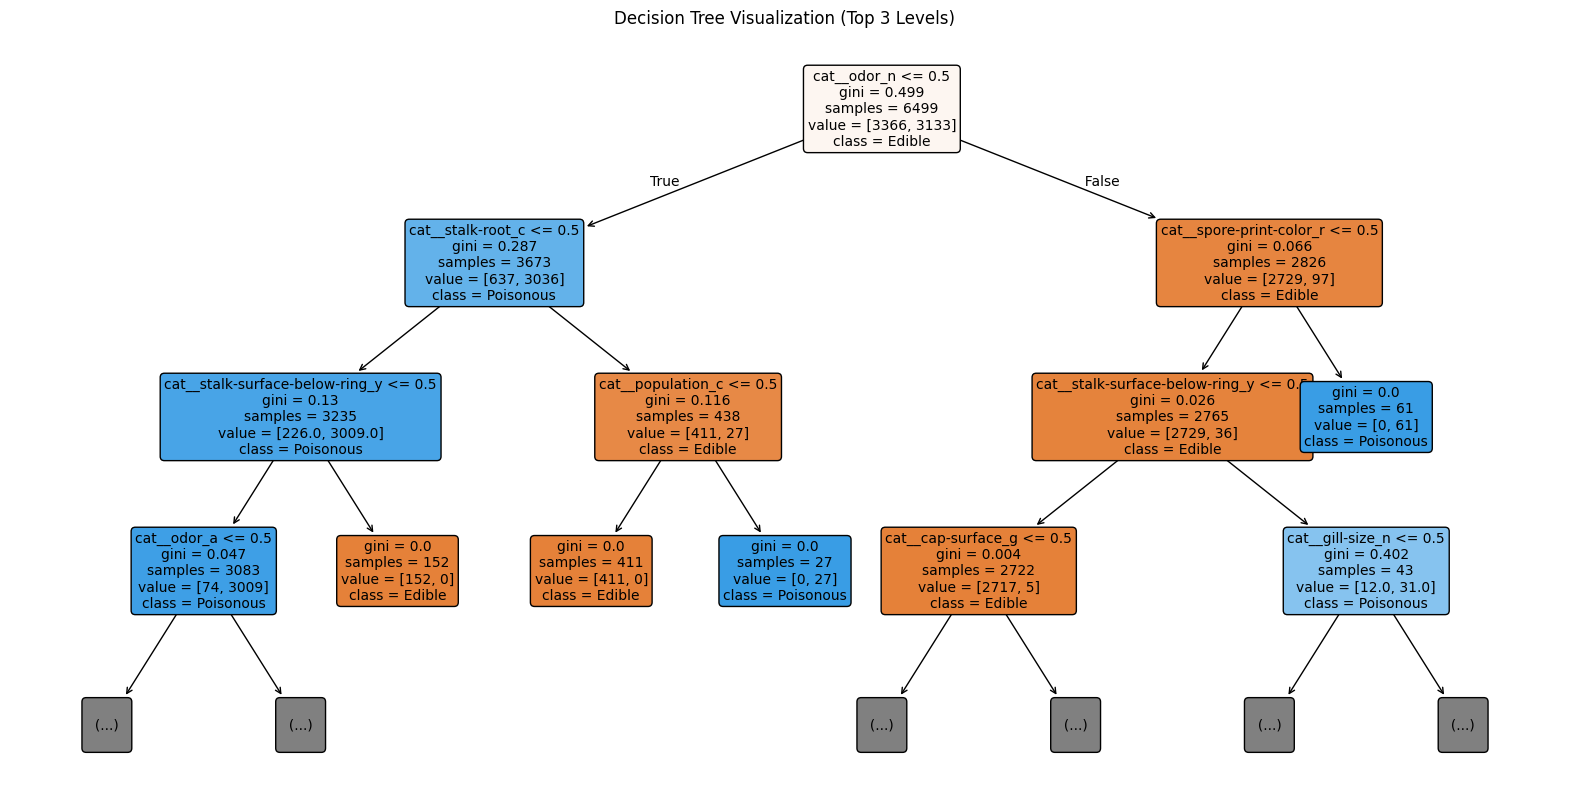

In [7]:
# Decision Tree with GridSearchCV
# Create pipeline with preprocessor and classifier
dt_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Define hyperparameter grid for tuning
param_grid_dt = {
    "clf__max_depth": [3, 5, 8, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}

# Setup Grid Search with Cross-Validation
grid_dt = GridSearchCV(
    dt_pipe,
    param_grid=param_grid_dt,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

# Run grid search
grid_dt.fit(X_train, y_train)

print("Best Decision Tree Params:", grid_dt.best_params_)
print("Best CV F1 Score:", grid_dt.best_score_)

# Evaluate the best model found
best_dt = grid_dt.best_estimator_
_ = evaluate_model("Decision Tree (tuned)",
                   best_dt, X_train, X_test, y_train, y_test)

# ============= Visualization Optimization =================

# 1. Extract feature names from the preprocessor
feature_names = best_dt.named_steps["preprocess"].get_feature_names_out()

# 2. Retrieve the classifier step from the pipeline
best_dt_clf = best_dt.named_steps["clf"]

# 3. Plot the tree (High DPI, adding feature_names and class_names)
plt.figure(figsize=(20, 10), dpi=100)
plot_tree(
    best_dt_clf,
    max_depth=3,                    # Limit depth to 3 for readability
    feature_names=feature_names,    # [Key] Show actual feature names
    class_names=["Edible", "Poisonous"],    # [Key] Show class names (0=Edible, 1=Poisonous)
    fontsize=10,                    # Increase font size
    filled=True,                    # Fill nodes with color based on purity
    rounded=True                    # Rounded corners for aesthetics
)
plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Random Forest Params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best CV F1 Score: 1.0
Model: Random Forest (tuned)
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
ROC AUC  : 1.0000

Confusion Matrix (Row=True, Col=Pred)
[[842   0]
 [  0 783]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Top 20 Feature Importances (Random Forest):


,feature,importance
27,odor_n,0.155879
36,gill-size_n,0.074632
24,odor_f,0.062844
35,gill-size_b,0.050492
61,stalk-surface-below-ring_k,0.048865
96,spore-print-color_h,0.046069
57,stalk-surface-above-ring_k,0.036367
37,gill-color_b,0.032876
94,ring-type_p,0.031501
21,bruises_t,0.026639


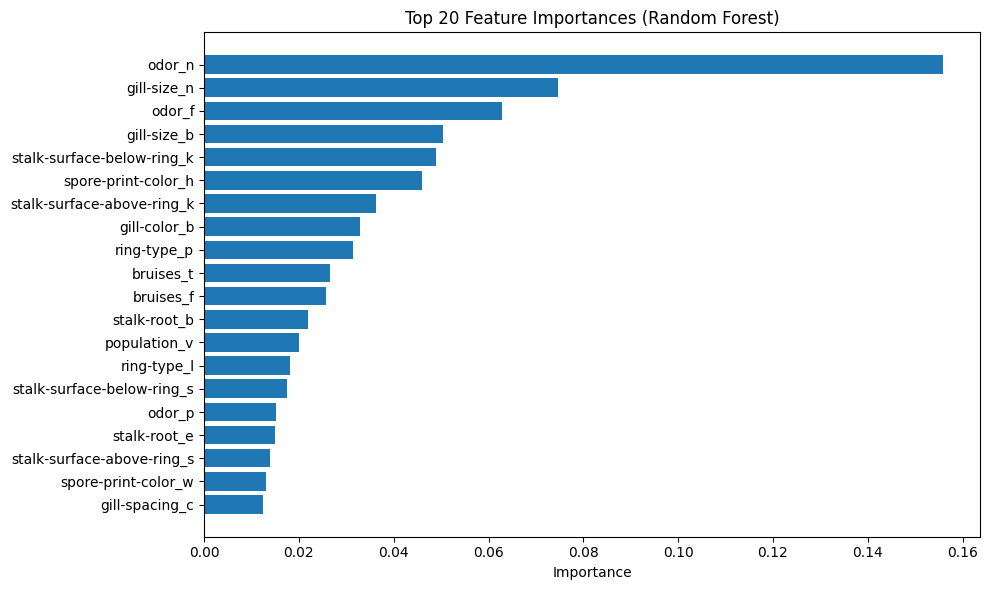

In [8]:
# Random Forest GridSearchCV + Feature Importance

# Create pipeline with preprocessor and Random Forest classifier
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# Define hyperparameter grid
param_grid_rf = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2]
}

# Setup Grid Search
grid_rf = GridSearchCV(
    rf_pipe,
    param_grid=param_grid_rf,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

# Run grid search (training)
grid_rf.fit(X_train, y_train)

print("Best Random Forest Params:", grid_rf.best_params_)
print("Best CV F1 Score:", grid_rf.best_score_)

# Evaluate the best model found
best_rf = grid_rf.best_estimator_
_ = evaluate_model("Random Forest (tuned)",
                   best_rf, X_train, X_test, y_train, y_test)

# ============= Feature Importance ==============

# 1. Get feature names from OneHotEncoder
ohe_in_pipe = best_rf.named_steps["preprocess"].named_transformers_["cat"]
ohe_feature_names = ohe_in_pipe.get_feature_names_out(categorical_features)

# 2. Extract importance scores from the trained model
rf_clf = best_rf.named_steps["clf"]
importances = rf_clf.feature_importances_

# 3. Create a DataFrame and sort by importance
feat_imp = pd.DataFrame({
    "feature": ohe_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nTop 20 Feature Importances (Random Forest):")
display(feat_imp.head(20))

# 4. Visualization
plt.figure(figsize=(10, 6))
topk = feat_imp.head(20)
plt.barh(topk["feature"][::-1], topk["importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()